In [2]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import pylops #
# from scipy import stats
# from scipy.stats import pearsonr as pearson
# import helper_functions as hf
# from tqdm import tqdm
# from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [3]:
# Usando o Volve
# filename = "data/volve.sgy"

# Caso tenha o dado de ABL, descomentar a linha abaixo
filename = "D:/Dados ABL/ABL_FULL_TIME_3D.sgy"

In [ ]:
f = segyio.open(filename, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
ntraces, nt = traces.shape

t = f.samples
il = f.attributes(189)[:]
xl = f.attributes(193)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

nil, nxl, nt = len(ilines), len(xlines), len(t)

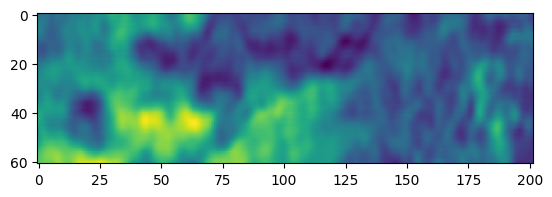

In [14]:
plt.imshow(d[..., 200])

29.528549194335938


Text(0.5, 1.0, 'Seção Sísmica')

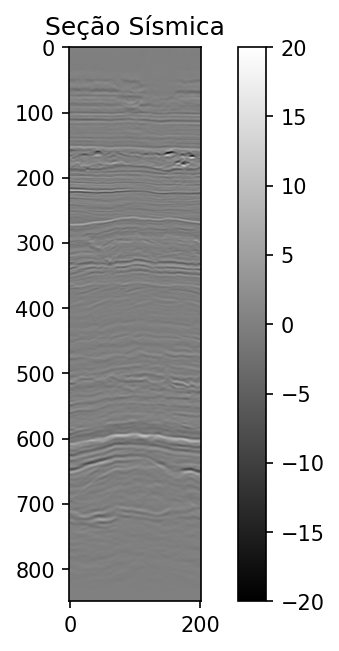

In [7]:
# d = d / np.max(d)
print(np.max(d))

plt.figure(dpi=150)

plt.imshow(d[60, :, :].T, vmin=-20, vmax=20, cmap="gray")
plt.colorbar()
plt.title("Seção Sísmica")

Text(0.5, 1.0, 'Traço sísmico iline 30 e xline 101')

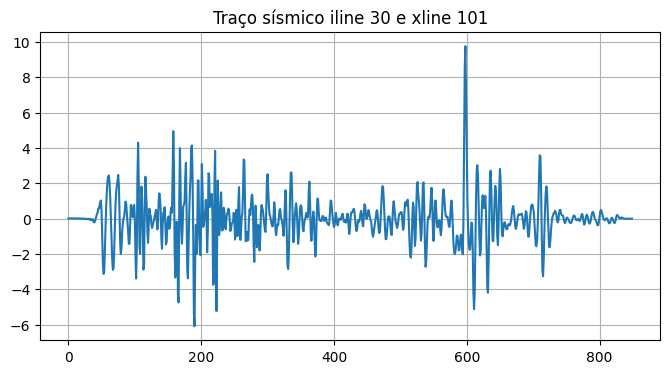

In [8]:
plt.figure(figsize=(8,4))
plt.plot(d[30, 101, :])
plt.grid()
plt.title("Traço sísmico iline 30 e xline 101")

In [9]:
"""
Simulação de um modelo de baixa!!
"""

cutoff_back = 6 
cutoff_gabarito = 30
fs = 128

data_imp_back = hf.butter_lowpass_filter(data_imp, cutoff_back, fs=fs, order=5)
data_imp_gab = hf.butter_lowpass_filter(data_imp, cutoff_gabarito, fs=fs, order=5)
data_vel_back = hf.butter_lowpass_filter(data_vel, cutoff_back, fs=fs, order=5)

NameError: name 'data_imp' is not defined

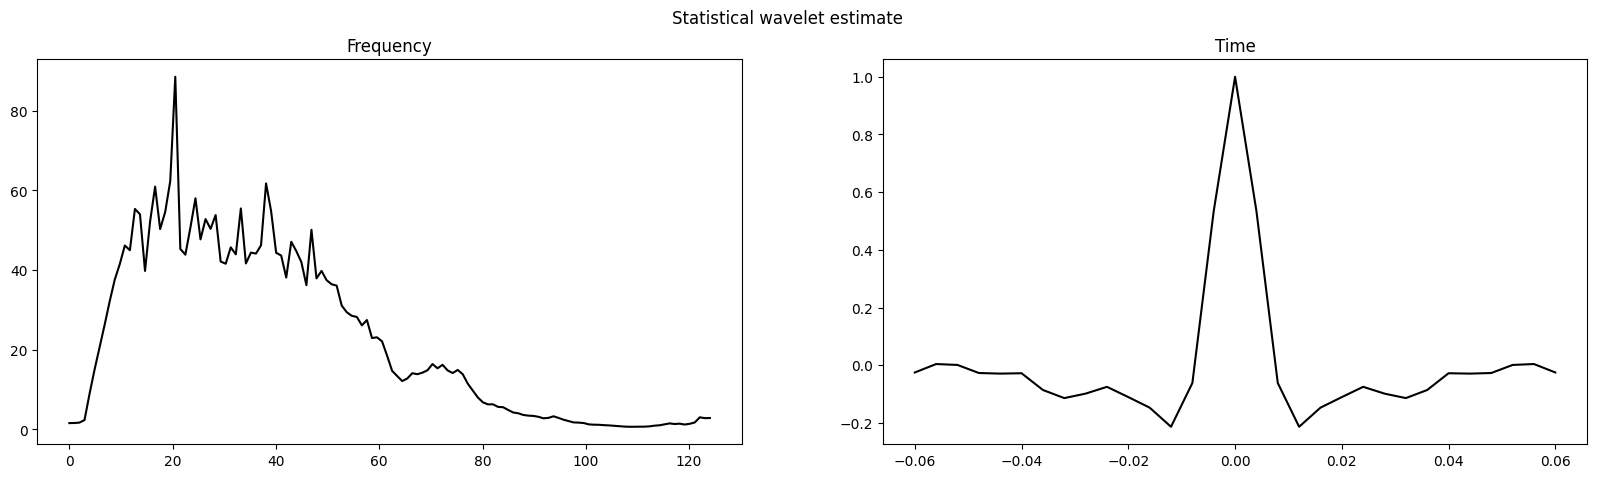

In [ ]:
# Wavelet time axis
t_wav = np.arange(16) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[::2, ::2, int(2500//dt) : int(3500//dt)], 2**8, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(2**8, d=dt/1000)

# Create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:16])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:2**8//2], wav_est_fft[:2**8//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

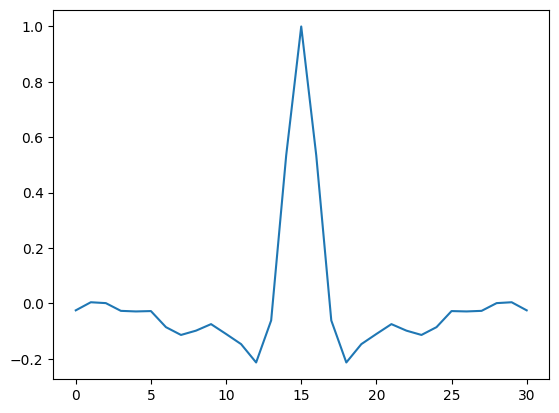

In [23]:
plt.plot(wav_est)

In [17]:
def estimate_wavelet_deterministic(seismic_data, sampling_rate):
    """
    Estimate the deterministic wavelet from seismic data.

    Parameters:
    seismic_data (np.ndarray): The seismic data array.
    tmin (float): The minimum time for the wavelet estimation.
    tmax (float): The maximum time for the wavelet estimation.
    trace_min (int, optional): The minimum trace index for slicing. Defaults to None.
    trace_max (int, optional): The maximum trace index for slicing. Defaults to None.

    Returns:
    pd.DataFrame: A DataFrame containing the time and amplitude of the estimated wavelet.
    np.ndarray: The estimated wavelet.
    np.ndarray: The frequency values.
    np.ndarray: The FFT of the estimated wavelet.
    """
    nt_wav = 16
    nfft = 2**8

    fft_result = np.fft.fft(seismic_data, nfft, axis=-1)

    wav_est_fft = np.mean(np.abs(fft_result), axis=0)

    fwest = np.fft.fftfreq(nfft, d=4 / 1000)
    wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
    wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
    wav_est = wav_est / wav_est.max()
    fwest = fwest[: nfft // 2]
    wav_est_fft = wav_est_fft[: nfft // 2]

    dt = sampling_rate / 1000  # Assuming the sampling interval is 4 ms
    time_values = np.arange(-nt_wav + 1, nt_wav) * dt
    
    return time_values, wav_est, fwest, wav_est_fft

twav_est, wav_est, fwest, wav_est_fft = estimate_wavelet_deterministic(d[..., 200:400], 4)

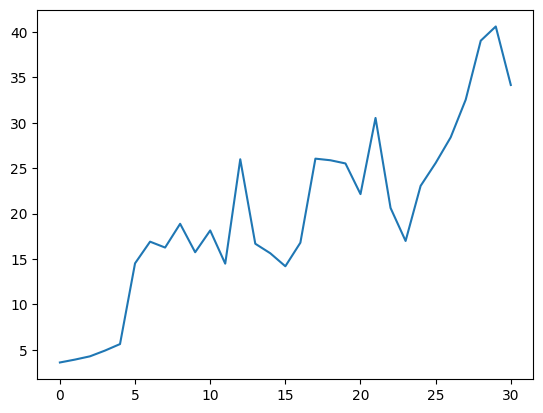

In [18]:
wav_est_final = []
wav_fft_final = []
timee = np.arange(-len(wav_est[:, 0]), len(wav_est[:, 0]), 1) / 1000

for i in range(len(wav_est[:, 0])):
    mean_wav_est = np.mean(wav_est[:, i])
    mean_est_fft = np.mean(wav_est_fft[:, i])
    
    wav_est_final.append(mean_wav_est)
    wav_fft_final.append(mean_est_fft)

wav_est_final = np.array(wav_est_final)
wav_fft_final = np.array(wav_fft_final)

# plt.plot(timee, wav_est_final)
plt.plot(wav_fft_final)

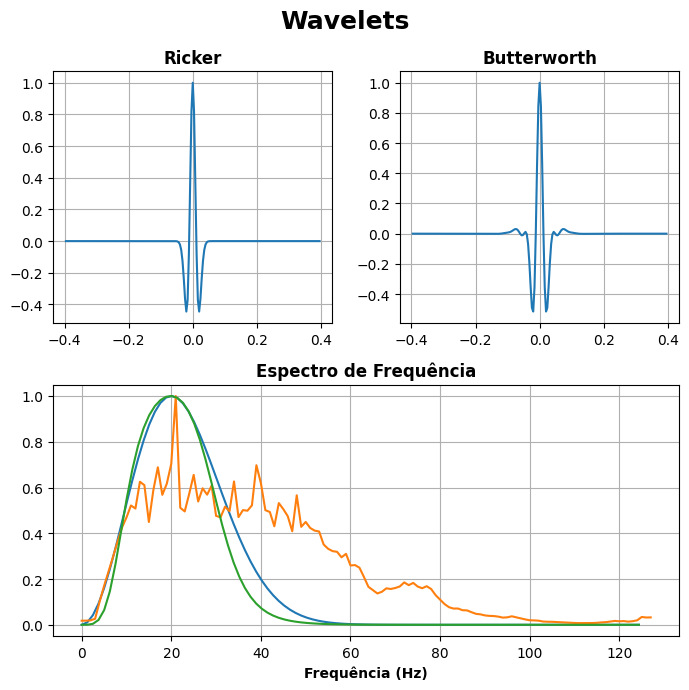

In [27]:
sample = 100
dt = 4
pkfq = 20
highfq = 30
lowfq = 10

twlet, wlet, freqs, fft = hf.generate_ricker(peak_freq=pkfq, samples=sample, dt=dt)
twlet_b, wlet_b, freqs_b, fft_b = hf.generate_butter(
    freq_hi=highfq, freq_low=lowfq, samples=sample, dt=dt
)

plt.figure(figsize=(7, 7))

plt.suptitle("Wavelets", fontsize=18, fontweight="bold")

plt.subplot2grid((2, 2), (0, 0))
plt.plot(twlet, wlet)
plt.tick_params(axis="both")
plt.title("Ricker", fontweight="bold")
plt.grid()

plt.subplot2grid((2, 2), (0, 1))
plt.plot(twlet_b, wlet_b)
plt.tick_params(axis="both")
plt.title("Butterworth", fontweight="bold")
plt.grid()

teste = wav_est_fft[:2**8//2]

plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.tick_params(axis="both")
plt.plot(freqs, fft, label="Ricker")
plt.plot(teste / np.max(teste), label="Estimado")
plt.title(
    "Espectro de Frequência", fontweight="bold"
)
plt.plot(freqs_b, fft_b, label="Butterworth")
plt.xlabel("Frequência (Hz)", fontweight="bold")
plt.grid()

plt.tight_layout()
plt.show()

In [142]:
np.shape(d)

(61, 202, 850)

In [143]:
nx, ny, nz = d.shape
print(nx, ny, nz)

61 202 850


In [144]:
d_inv2_ppop = pylops.avo.poststack.PoststackLinearModelling(
    wlet / 2, nt0=nz, spatdims=1, explicit=True
)

c:\Users\Icarl\AppData\Local\Programs\Python\Python313\Lib\site-packages\pylops\utils\signalprocessing.py:46: FutureWarning: A new implementation of convmtx is provided in v2.2.0 to match MATLAB's convmtx method as stated in the docstring. The implementation of convmtx provided prior to v2.2.0 was instead not consistent with the documentation. Users are highly encouraged to modify their codes accordingly.
  warnings.warn(


In [145]:
inv_d = np.zeros_like(d)

for ix, iy in tqdm(np.ndindex(nx, ny), desc="Processing traces"):
    d_inv2 = (
        pylops.optimization.leastsquares.normal_equations_inversion(
            Op=d_inv2_ppop,
            y=d[ix, iy, :],
            Regs=[pylops.Identity(nz)],
            epsI=0.1,
            # x0=impedance_trace,
            engine="scipy",
            **dict(maxiter=1000)
        )[0]
    )
    inv_d[ix, iy, :] = d_inv2.reshape(nz)
    
# inv_d = inv_d / np.max(inv_d)

Processing traces: 12322it [00:49, 251.30it/s]


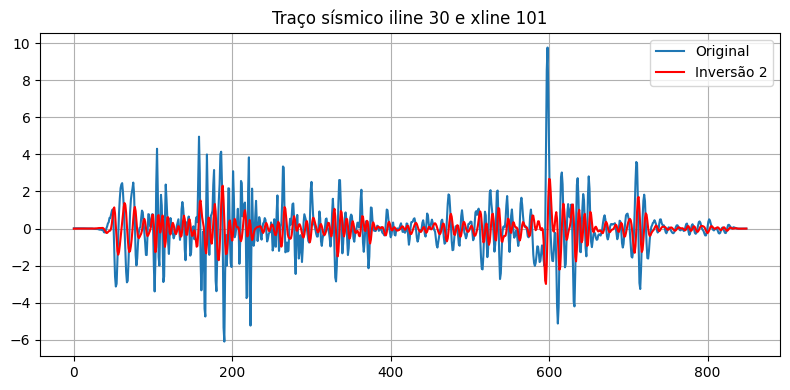

In [146]:
# d_inv = pylops.avo.poststack.PoststackInversion(d, wav=wlet, explicit=True)[0]

plt.figure(figsize=(8,4))
plt.plot(d[30, 101, :], label="Original")
# plt.plot(d_inv[30, 101, :], label="Inversão 1")
plt.plot(inv_d[30, 101, :], color="red", label="Inversão 2")
plt.grid()
plt.title("Traço sísmico iline 30 e xline 101")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [156]:
print(d[30, 101, :][600])
print(inv_d[30, 101, :][600])

3.843904495239258
2.675102718287439


In [161]:
correlation_coefficient = pearson(d[30, 101, :].flatten(), inv_d[30, 101, :].flatten())[0]
print(correlation_coefficient)

MAPE_calc = MAPE(d[30, 101, :], inv_d[30, 101, :])
print(MAPE_calc)

-1.4271426385711189e-08
274051591966.88217


Post-stack seismic modelling is the process of constructing seismic post-stack data from a profile of an elastic parameter (Impedance or Velocity) of choice in time (or depth) domain. This can be easily achieved using the following forward model:

$$ d(t, \theta = 0) = w (t) \cdot \frac{d \ln m(t)}{dt} $$

where $m(t)$ is the elastic parameter profile and $w (t)$ is the time domain seismic wavelet. In compact form:

$$ \text{d} = \textbf{WDm} $$

In the special case of acoustic impedance ($m(t) = AI(t)$), the modelling operator can be used to create zero-offset data:

$$ d(t, \theta = 0) = \frac{1}{2} w (t) \cdot \frac{d \ln m(t)}{dt} $$

where the scaling factor $\frac{1}{2}$ can be easily included in the wavelet

In [11]:
nx , ny , nz = data_amp.shape

PostStackOperator = pylops.avo.poststack.PoststackLinearModelling(
    wlet / 2, nt0=nz, spatdims=1, explicit=True
)

c:\Users\aalbano\AppData\Local\Programs\Python\Python313\Lib\site-packages\pylops\utils\signalprocessing.py:46: FutureWarning: A new implementation of convmtx is provided in v2.2.0 to match MATLAB's convmtx method as stated in the docstring. The implementation of convmtx provided prior to v2.2.0 was instead not consistent with the documentation. Users are highly encouraged to modify their codes accordingly.
  warnings.warn(


Correlação: 0.78


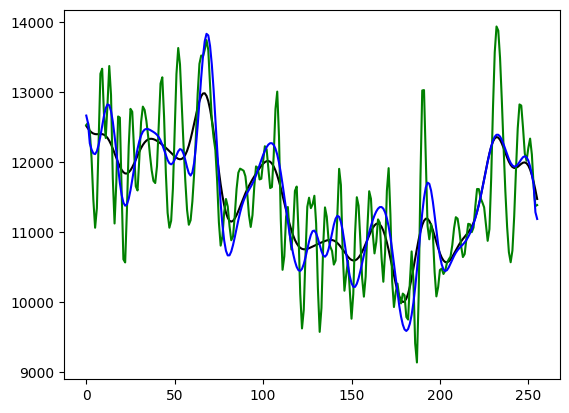

In [12]:
section_inv = 200

inverted_impedance_ricker = (
    pylops.optimization.leastsquares.normal_equations_inversion(
        Op=PostStackOperator,
        y=data_amp[section_inv, section_inv, :],
        Regs=[],
        epsI=2,
        x0=data_imp_back[section_inv, section_inv, :],
        engine="scipy",
        **dict(maxiter=1000)
    )[0]
)

inv_final = inverted_impedance_ricker + data_imp_back[section_inv, section_inv, :]
plt.plot(data_imp_back[section_inv, section_inv, :], color="black")
plt.plot(data_imp_gab[section_inv, section_inv, :], color="green")
plt.plot(inv_final, color="blue")


correlation_coefficient = pearson(data_imp_gab[section_inv, section_inv, :], inv_final)[0]

print(f"Correlação: {correlation_coefficient:.2f}")